In [2]:
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GroupKFold, train_test_split, learning_curve
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
def compute_learning_curve_data(model, X_train, y_train, groups):
    from sklearn.model_selection import GroupKFold, learning_curve

    cv = GroupKFold(n_splits=5)
    
    # Data dictionary to store results
    results = {}
    
    for scoring in tqdm(['accuracy', 'recall', 'f1'], desc="Computing curves"):
        train_sizes, train_scores, test_scores = learning_curve(
            model, X_train, y_train, groups=groups, cv=cv, n_jobs=-1, 
            train_sizes=np.linspace(.1, 1.0, 10), scoring=scoring)
        
        results[scoring] = {
            'train_sizes': train_sizes,
            'train_scores': train_scores,
            'test_scores': test_scores
        }
    
    # Generate file name based on the model's class name
    model_name = model.__class__.__name__
    filename = f"{model_name}_learning_curve_data.pkl"
    
    # Save results to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(results, f)

    return results

In [4]:
def plot_combined_learning_curve(models_data):
    score_titles = {
        'accuracy': 'Accuracy',
        'recall': 'Recall',
        'f1': 'F1 Score'
    }

    model_styles = {
        'LogisticRegression': {'color': 'r', 'marker': 'o'},
        'RandomForestClassifier': {'color': 'g', 'marker': '^'},
        'KNeighborsClassifier': {'color': 'b', 'marker': 's'}
    }

    for scoring in score_titles.keys():
        fig, axarr = plt.subplots(1, 2, figsize=(15, 6), sharey=True)  # 1 row, 2 columns
        fig.suptitle(f"Learning Curve with {score_titles[scoring]}", fontsize=16)

        # Plot training curve for all models for the current scoring metric
        axarr[0].set_title("Training Curve")
        axarr[0].set_xlabel("Training examples")
        axarr[0].set_ylabel(score_titles[scoring])
        axarr[0].grid()

        for model_name, data in models_data.items():
            train_sizes = data[scoring]['train_sizes']
            train_scores_mean = np.mean(data[scoring]['train_scores'], axis=1)
            train_scores_std = np.std(data[scoring]['train_scores'], axis=1)
            
            axarr[0].plot(train_sizes, train_scores_mean, 
                          color=model_styles[model_name]['color'], 
                          marker=model_styles[model_name]['marker'])
            axarr[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                                  train_scores_mean + train_scores_std, alpha=0.1, color=model_styles[model_name]['color'])

        # Plot validation curve for all models for the current scoring metric
        axarr[1].set_title("Validation Curve")
        axarr[1].set_xlabel("Training examples")
        axarr[1].grid()

        for model_name, data in models_data.items():
            train_sizes = data[scoring]['train_sizes']
            test_scores_mean = np.mean(data[scoring]['test_scores'], axis=1)
            test_scores_std = np.std(data[scoring]['test_scores'], axis=1)
            
            axarr[1].plot(train_sizes, test_scores_mean, 
                          color=model_styles[model_name]['color'], 
                          marker=model_styles[model_name]['marker'], 
                          label=f"{model_name}")
            axarr[1].fill_between(train_sizes, test_scores_mean - test_scores_std,
                                  test_scores_mean + test_scores_std, alpha=0.1, color=model_styles[model_name]['color'])

        # Add common legend
        fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # adjust title position
        plt.show()


In [9]:
def load_learning_curve_data(model_name):
    with open(f"{model_name}_learning_curve_data.pkl", 'rb') as f:
        return pickle.load(f)

In [5]:
df_data = pd.read_pickle('df_data.pkl')
df_data

,image_id,x,y,0,1,2,3,4,5,6,...,429,430,431,432,433,434,435,436,437,label
0,129D1,42,234,0.183241,0.183241,0.177040,0.181723,0.176845,0.182095,0.176937,...,0.390600,0.394394,0.398004,0.402821,0.183241,0.183241,0.183241,0.183241,0.0,1
1,129D1,33,156,0.183241,0.183241,0.179713,0.177953,0.174137,0.177956,0.171644,...,0.415097,0.417611,0.421339,0.430918,0.183241,0.183241,0.183241,0.183241,0.0,1
2,129D1,78,78,0.183241,0.183241,0.177950,0.170932,0.168615,0.170199,0.166566,...,0.401058,0.406532,0.407522,0.410457,0.419562,0.183241,0.183241,0.183241,0.0,1
3,129D1,42,147,0.183241,0.183241,0.179855,0.182989,0.178902,0.182606,0.177878,...,0.423789,0.430713,0.436174,0.441805,0.183241,0.183241,0.183241,0.183241,0.0,1
4,129D1,42,235,0.183241,0.183241,0.172990,0.176540,0.171127,0.176303,0.171870,...,0.377796,0.379615,0.383085,0.388312,0.183241,0.183241,0.183241,0.183241,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586594,05814,59,147,0.161424,0.161424,0.165725,0.164123,0.161058,0.160869,0.160224,...,0.358010,0.359653,0.364118,0.368421,0.161424,0.161424,0.161424,0.161424,0.0,0
586595,05814,52,148,0.161424,0.161424,0.172172,0.170590,0.168009,0.167722,0.166930,...,0.395572,0.396083,0.399904,0.405905,0.161424,0.161424,0.161424,0.161424,0.0,0
586596,05814,57,148,0.161424,0.161424,0.166005,0.164945,0.161472,0.161788,0.160700,...,0.364860,0.364178,0.365183,0.368164,0.161424,0.161424,0.161424,0.161424,0.0,0
586597,05814,57,149,0.161424,0.161424,0.161848,0.160963,0.157673,0.158131,0.156798,...,0.362013,0.361641,0.362803,0.366092,0.161424,0.161424,0.161424,0.161424,0.0,0


In [6]:
feature_columns = list(range(0, 438))
duplicates = df_data.duplicated(subset=feature_columns, keep=False)

num_duplicates = duplicates.sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 46


In [7]:
df_data = df_data[~duplicates]

duplicates = df_data.duplicated(subset=feature_columns, keep=False)

num_duplicates = duplicates.sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


In [8]:
zero_coordinates = df_data[(df_data['x'] == 0) | (df_data['y'] == 0)]

num_zero_coordinates = len(zero_coordinates)

print(f'Number of zero coordinates rows: {num_zero_coordinates}')

Number of zero coordinates rows: 0


In [9]:
missing_count = df_data.isnull().sum().sum()

print(f'Number of missing values: {missing_count}')

Number of missing values: 0


In [10]:
constant_features = [col for col in df_data.columns if df_data[col].nunique() == 1]

print(f'Number of constant features: {len(constant_features)}')

Number of constant features: 1


In [11]:
num_unique_elements = df_data['image_id'].nunique()
print(f'Number of images: {num_unique_elements}')

Number of images: 337


In [12]:
features = df_data.columns[3:-1]
label = df_data.columns[-1]

scaler = MinMaxScaler()
X_data = scaler.fit_transform(df_data[features])

y_data = df_data[label].values

groups = df_data["image_id"].values
X_data, y_data, groups = shuffle(X_data, y_data, groups)

In [13]:
counts = np.bincount(y_data)
num_zeros = counts[0]
num_ones = counts[1]

print(f"Number of zeros: {num_zeros}")
print(f"Number of ones: {num_ones}")

Number of zeros: 586576
Number of ones: 322877


In [14]:
lr = LogisticRegression(solver='newton-cg', n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

In [15]:
lr_data = compute_learning_curve_data(lr, X_data, y_data, groups)

Computing curves: 100%|██████████| 3/3 [19:09<00:00, 383.18s/it]


In [15]:
rf_data = compute_learning_curve_data(rf, X_data, y_data, groups)

Computing curves: 100%|██████████| 3/3 [34:06<00:00, 682.11s/it]


In [ ]:
knn_data = compute_learning_curve_data(knn, X_data, y_data, groups)

Computing curves:   0%|          | 0/3 [00:00<?, ?it/s]

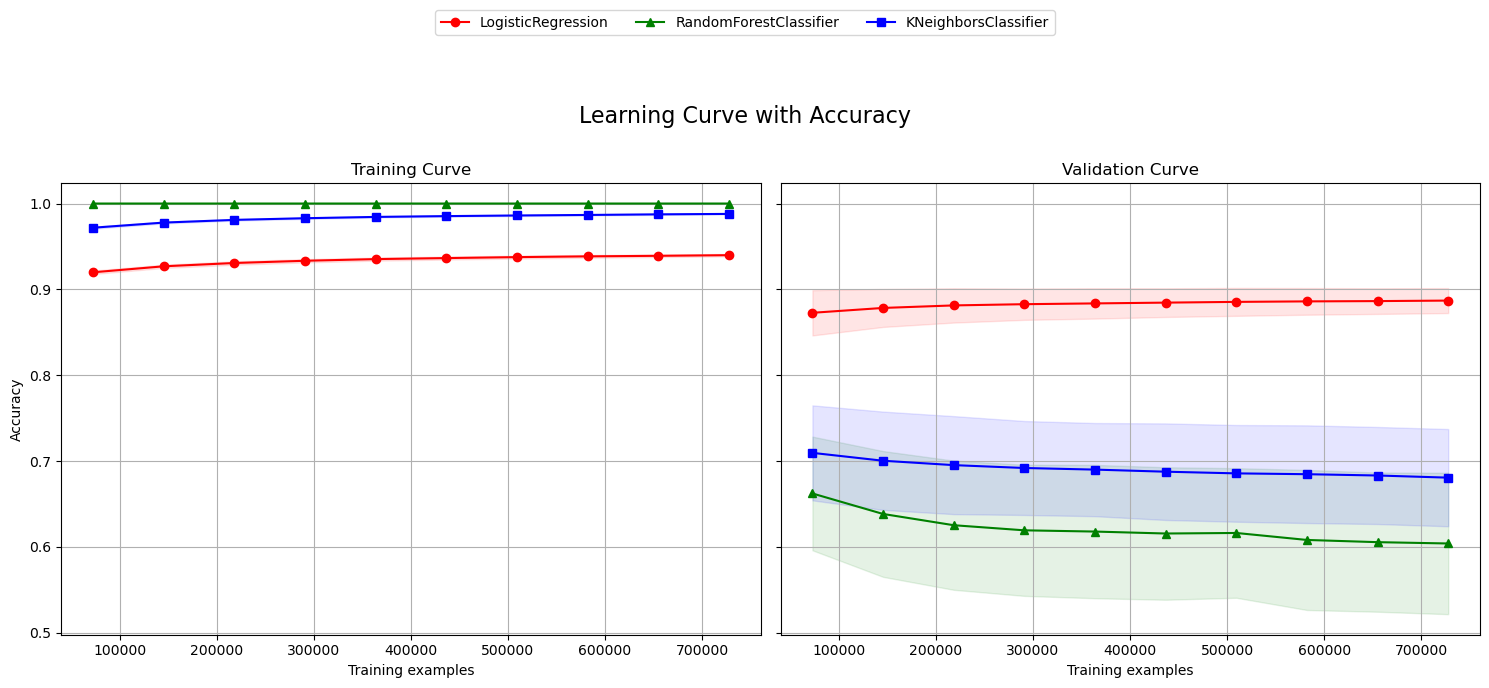

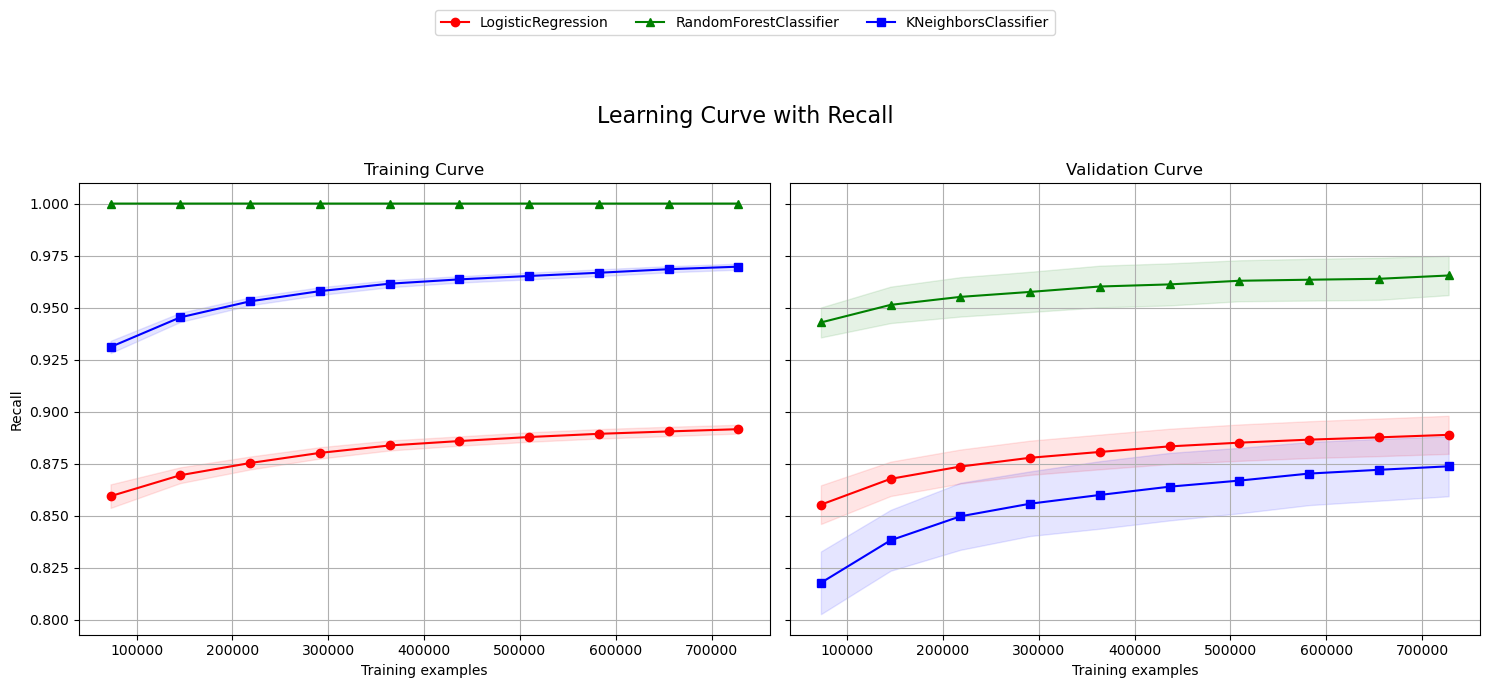

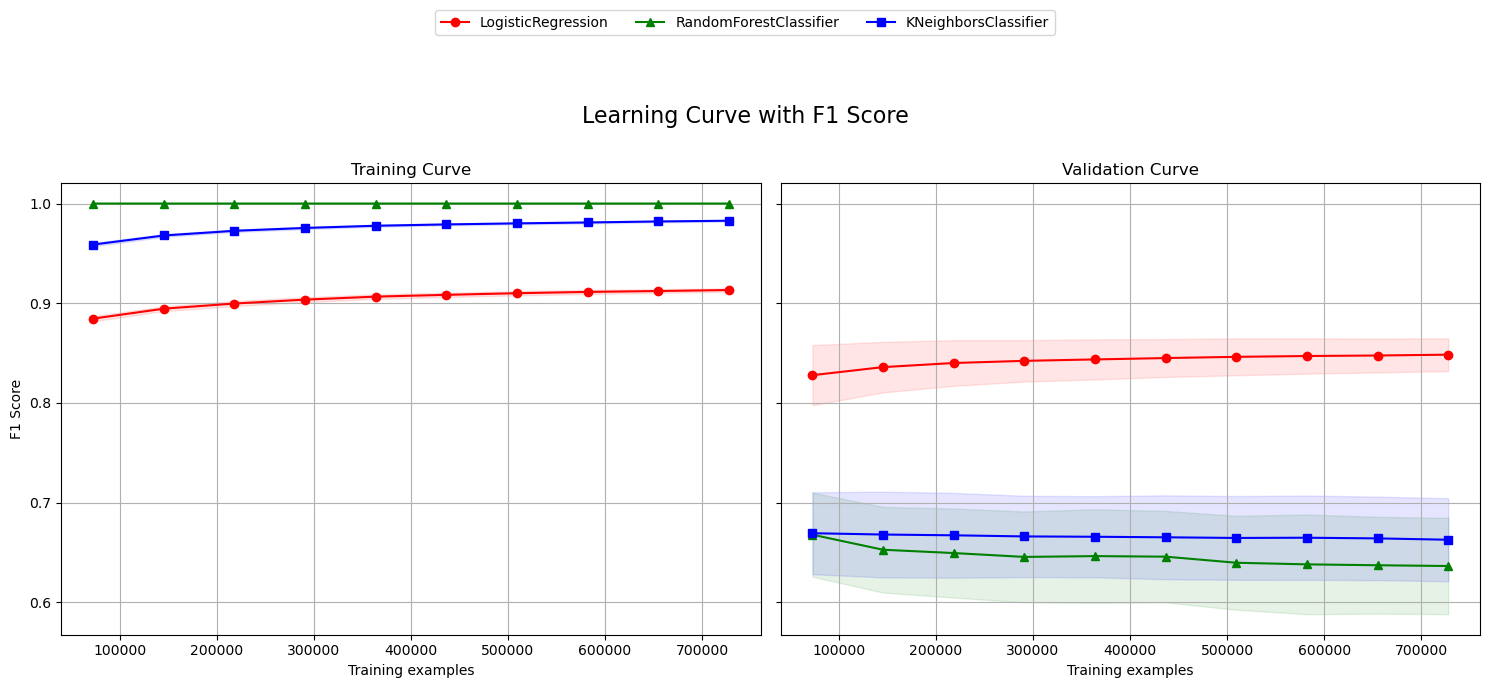

In [10]:
models = ['LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier']

# Load data for all models
models_data = {model_name: load_learning_curve_data(model_name) for model_name in models}

# Plot combined learning curves
plot_combined_learning_curve(models_data)